In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
BATCH_SIZE = 64
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40

transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), torchvision.transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])
trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


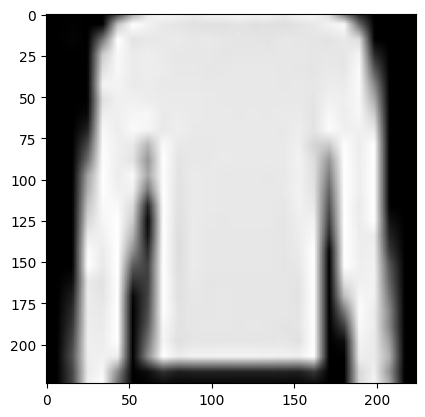

Label: 2


In [7]:
#nex iter gets next 100 images
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[7][0].squeeze()
label = train_labels[7]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [8]:
from torchvision import models
# all_models = models.list_models()
m1 = torchvision.models.get_model("mobilenet_v3_small", num_classes=10, num_channels=1)
# Move your model to the GPU if available
m1.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [10]:
batch1, label1=next(iter(trainloader))


In [11]:
# predicted = m1(batch1.to(device))

In [12]:
# Freeze all layers
for param in m1.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in m1.classifier.parameters():
    param.requires_grad = True

In [ ]:
import pickle

batch_tr_loss = {}
batch_te_loss = {}
batch_sizes = [8, 16, 32, 64]

best_test_loss = float('inf')

trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)

for BATCH_SIZE in batch_sizes:

  m1 = torchvision.models.get_model("mobilenet_v3_small", num_classes=10, num_channels=1)
  # Move your model to the GPU if available
  m1.to(device)
  optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
  loss_fn = torch.nn.CrossEntropyLoss()
  # Freeze all layers
  for param in m1.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in m1.classifier.parameters():
      param.requires_grad = True

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
  testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

  # epoch loss and accuracy
  tr_loss, tr_acc = [], []
  te_loss, te_acc = [], []

  for t in (range(NUM_OF_EPOCHS)):
      m1.train()
      batch_loss, batch_accuracy = [], []
      print(f"Epoch {t+1} Training...")
      for X,y in tqdm(trainloader):
          X = X.to(device)
          y = y.to(device)
          predicted = m1(X)
          loss = loss_fn(predicted, y)
          batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
          batch_loss.append(float(loss.item()))

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      batches = len(batch_loss)
      tr_loss.append(sum(batch_loss)/batches)
      tr_acc.append(sum(batch_accuracy)/batches)

      m1.eval()
      with torch.no_grad():
          batch_loss, batch_accuracy = [], []
          print(f"Epoch {t+1} Testing...")
          for X,y in tqdm(testloader):
              X = X.to(device)
              y = y.to(device)
              predicted = m1(X)
              loss = loss_fn(predicted, y)
              batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
              batch_loss.append(float(loss.item()))

          batches = len(batch_loss)
          te_loss.append(sum(batch_loss)/batches)
          te_acc.append(sum(batch_accuracy)/batches)

      # Save the model's weights after each epoch
      torch.save(m1.state_dict(), f"model_weights/{BATCH_SIZE}_model_weights.pth")

      # Check if the current test loss is the best so far
      if te_loss[-1] < best_test_loss:
          best_test_loss = te_loss[-1]
          # Save the model's weights with the best test loss
          torch.save(m1.state_dict(), f"model_weights/{BATCH_SIZE}_best_model_weights.pth")

      print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc[-1]):>0.2f}%, Train_loss: {tr_loss[-1]:>8f}, Test_accuracy: {(100*te_acc[-1]):>0.2f}%, Test_loss: {te_loss[-1]:>8f}")
  batch_tr_loss[BATCH_SIZE] = tr_loss
  batch_te_loss[BATCH_SIZE] = te_loss
  # Save the dictionary to a file
  with open("batch_tr_loss.pkl", 'wb') as file:
      pickle.dump(batch_tr_loss, file)

  # Save the dictionary to a file
  with open("batch_te_loss.pkl", 'wb') as file:
      pickle.dump(batch_te_loss, file)

Epoch 1 Training...


100%|██████████| 7500/7500 [03:00<00:00, 41.52it/s]


Epoch 1 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.67it/s]


Epoch 1: Train_accuracy: 40.65%, Train_loss: 1.590126, Test_accuracy: 50.07%, Test_loss: 1.410878
Epoch 2 Training...


100%|██████████| 7500/7500 [02:50<00:00, 44.03it/s]


Epoch 2 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.19it/s]


Epoch 2: Train_accuracy: 46.37%, Train_loss: 1.431462, Test_accuracy: 53.25%, Test_loss: 1.350087
Epoch 3 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.70it/s]


Epoch 3 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 48.97it/s]


Epoch 3: Train_accuracy: 48.39%, Train_loss: 1.387237, Test_accuracy: 57.59%, Test_loss: 1.175966
Epoch 4 Training...


100%|██████████| 7500/7500 [02:54<00:00, 42.93it/s]


Epoch 4 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 48.94it/s]


Epoch 4: Train_accuracy: 50.09%, Train_loss: 1.343091, Test_accuracy: 58.72%, Test_loss: 1.170729
Epoch 5 Training...


100%|██████████| 7500/7500 [02:54<00:00, 43.02it/s]


Epoch 5 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 48.98it/s]


Epoch 5: Train_accuracy: 51.09%, Train_loss: 1.319413, Test_accuracy: 58.27%, Test_loss: 1.187944
Epoch 6 Training...


100%|██████████| 7500/7500 [02:48<00:00, 44.55it/s]


Epoch 6 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.23it/s]


Epoch 6: Train_accuracy: 52.01%, Train_loss: 1.286354, Test_accuracy: 58.59%, Test_loss: 1.235835
Epoch 7 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.68it/s]


Epoch 7 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.25it/s]


Epoch 7: Train_accuracy: 52.26%, Train_loss: 1.276863, Test_accuracy: 60.40%, Test_loss: 1.164656
Epoch 8 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.82it/s]


Epoch 8 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 51.75it/s]


Epoch 8: Train_accuracy: 53.23%, Train_loss: 1.258815, Test_accuracy: 59.02%, Test_loss: 1.202956
Epoch 9 Training...


100%|██████████| 7500/7500 [02:46<00:00, 45.14it/s]


Epoch 9 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.71it/s]


Epoch 9: Train_accuracy: 53.40%, Train_loss: 1.253092, Test_accuracy: 61.82%, Test_loss: 1.077449
Epoch 10 Training...


100%|██████████| 7500/7500 [02:46<00:00, 45.15it/s]


Epoch 10 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.43it/s]


Epoch 10: Train_accuracy: 54.02%, Train_loss: 1.235569, Test_accuracy: 61.56%, Test_loss: 1.113893
Epoch 11 Training...


100%|██████████| 7500/7500 [02:49<00:00, 44.23it/s]


Epoch 11 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.64it/s]


Epoch 11: Train_accuracy: 54.28%, Train_loss: 1.232142, Test_accuracy: 60.52%, Test_loss: 1.126893
Epoch 12 Training...


100%|██████████| 7500/7500 [02:51<00:00, 43.84it/s]


Epoch 12 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.79it/s]


Epoch 12: Train_accuracy: 54.60%, Train_loss: 1.220618, Test_accuracy: 61.12%, Test_loss: 1.111567
Epoch 13 Training...


100%|██████████| 7500/7500 [02:46<00:00, 45.04it/s]


Epoch 13 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.98it/s]


Epoch 13: Train_accuracy: 55.06%, Train_loss: 1.212507, Test_accuracy: 62.37%, Test_loss: 1.089934
Epoch 14 Training...


100%|██████████| 7500/7500 [02:57<00:00, 42.33it/s]


Epoch 14 Testing...


100%|██████████| 1250/1250 [00:27<00:00, 44.81it/s]


Epoch 14: Train_accuracy: 54.87%, Train_loss: 1.215217, Test_accuracy: 63.64%, Test_loss: 1.059717
Epoch 15 Training...


100%|██████████| 7500/7500 [03:02<00:00, 41.07it/s]


Epoch 15 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.18it/s]


Epoch 15: Train_accuracy: 55.64%, Train_loss: 1.196747, Test_accuracy: 63.66%, Test_loss: 1.078282
Epoch 16 Training...


100%|██████████| 7500/7500 [02:52<00:00, 43.39it/s]


Epoch 16 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 48.29it/s]


Epoch 16: Train_accuracy: 55.56%, Train_loss: 1.196458, Test_accuracy: 63.68%, Test_loss: 1.067088
Epoch 17 Training...


100%|██████████| 7500/7500 [02:51<00:00, 43.77it/s]


Epoch 17 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.54it/s]


Epoch 17: Train_accuracy: 55.66%, Train_loss: 1.193222, Test_accuracy: 63.64%, Test_loss: 1.039134
Epoch 18 Training...


100%|██████████| 7500/7500 [02:45<00:00, 45.23it/s]


Epoch 18 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 51.01it/s]


Epoch 18: Train_accuracy: 56.08%, Train_loss: 1.181002, Test_accuracy: 63.99%, Test_loss: 1.024375
Epoch 19 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.82it/s]


Epoch 19 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.52it/s]


Epoch 19: Train_accuracy: 56.17%, Train_loss: 1.181553, Test_accuracy: 64.20%, Test_loss: 1.053088
Epoch 20 Training...


100%|██████████| 7500/7500 [02:51<00:00, 43.67it/s]


Epoch 20 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.77it/s]


Epoch 20: Train_accuracy: 55.96%, Train_loss: 1.184346, Test_accuracy: 64.35%, Test_loss: 1.050352
Epoch 21 Training...


100%|██████████| 7500/7500 [02:50<00:00, 43.97it/s]


Epoch 21 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.19it/s]


Epoch 21: Train_accuracy: 56.56%, Train_loss: 1.172724, Test_accuracy: 63.71%, Test_loss: 1.049706
Epoch 22 Training...


100%|██████████| 7500/7500 [02:50<00:00, 43.87it/s]


Epoch 22 Testing...


100%|██████████| 1250/1250 [00:26<00:00, 48.01it/s]


Epoch 22: Train_accuracy: 56.44%, Train_loss: 1.172377, Test_accuracy: 64.32%, Test_loss: 1.093827
Epoch 23 Training...


100%|██████████| 7500/7500 [02:50<00:00, 44.09it/s]


Epoch 23 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 48.82it/s]


Epoch 23: Train_accuracy: 56.81%, Train_loss: 1.163210, Test_accuracy: 62.65%, Test_loss: 1.095481
Epoch 24 Training...


100%|██████████| 7500/7500 [02:53<00:00, 43.30it/s]


Epoch 24 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 48.95it/s]


Epoch 24: Train_accuracy: 57.14%, Train_loss: 1.155306, Test_accuracy: 64.60%, Test_loss: 1.038756
Epoch 25 Training...


100%|██████████| 7500/7500 [02:49<00:00, 44.36it/s]


Epoch 25 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.24it/s]


Epoch 25: Train_accuracy: 57.24%, Train_loss: 1.158895, Test_accuracy: 65.01%, Test_loss: 1.038683
Epoch 26 Training...


100%|██████████| 7500/7500 [02:46<00:00, 44.92it/s]


Epoch 26 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.76it/s]


Epoch 26: Train_accuracy: 56.95%, Train_loss: 1.157228, Test_accuracy: 64.05%, Test_loss: 1.049054
Epoch 27 Training...


100%|██████████| 7500/7500 [02:49<00:00, 44.22it/s]


Epoch 27 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.76it/s]


Epoch 27: Train_accuracy: 57.07%, Train_loss: 1.153361, Test_accuracy: 65.38%, Test_loss: 0.999505
Epoch 28 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.72it/s]


Epoch 28 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.68it/s]


Epoch 28: Train_accuracy: 57.37%, Train_loss: 1.147262, Test_accuracy: 65.62%, Test_loss: 0.997110
Epoch 29 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.84it/s]


Epoch 29 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.90it/s]


Epoch 29: Train_accuracy: 57.46%, Train_loss: 1.149718, Test_accuracy: 64.57%, Test_loss: 1.031458
Epoch 30 Training...


100%|██████████| 7500/7500 [02:46<00:00, 45.00it/s]


Epoch 30 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.05it/s]


Epoch 30: Train_accuracy: 57.66%, Train_loss: 1.140966, Test_accuracy: 64.61%, Test_loss: 1.033917
Epoch 31 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.78it/s]


Epoch 31 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.28it/s]


Epoch 31: Train_accuracy: 57.69%, Train_loss: 1.144292, Test_accuracy: 65.47%, Test_loss: 1.007083
Epoch 32 Training...


100%|██████████| 7500/7500 [02:45<00:00, 45.24it/s]


Epoch 32 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.97it/s]


Epoch 32: Train_accuracy: 57.84%, Train_loss: 1.140300, Test_accuracy: 65.89%, Test_loss: 0.991885
Epoch 33 Training...


100%|██████████| 7500/7500 [02:45<00:00, 45.24it/s]


Epoch 33 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.75it/s]


Epoch 33: Train_accuracy: 58.03%, Train_loss: 1.142781, Test_accuracy: 64.97%, Test_loss: 1.012661
Epoch 34 Training...


100%|██████████| 7500/7500 [02:48<00:00, 44.58it/s]


Epoch 34 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 51.22it/s]


Epoch 34: Train_accuracy: 57.60%, Train_loss: 1.139489, Test_accuracy: 64.79%, Test_loss: 1.043563
Epoch 35 Training...


100%|██████████| 7500/7500 [02:47<00:00, 44.78it/s]


Epoch 35 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.32it/s]


Epoch 35: Train_accuracy: 58.19%, Train_loss: 1.131045, Test_accuracy: 64.78%, Test_loss: 1.038181
Epoch 36 Training...


100%|██████████| 7500/7500 [02:46<00:00, 45.06it/s]


Epoch 36 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.05it/s]


Epoch 36: Train_accuracy: 58.21%, Train_loss: 1.129560, Test_accuracy: 64.79%, Test_loss: 1.022345
Epoch 37 Training...


100%|██████████| 7500/7500 [02:49<00:00, 44.20it/s]


Epoch 37 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 48.71it/s]


Epoch 37: Train_accuracy: 57.99%, Train_loss: 1.130604, Test_accuracy: 65.50%, Test_loss: 1.026246
Epoch 38 Training...


100%|██████████| 7500/7500 [02:51<00:00, 43.71it/s]


Epoch 38 Testing...


100%|██████████| 1250/1250 [00:25<00:00, 49.76it/s]


Epoch 38: Train_accuracy: 58.14%, Train_loss: 1.127330, Test_accuracy: 66.35%, Test_loss: 0.999459
Epoch 39 Training...


100%|██████████| 7500/7500 [02:46<00:00, 44.96it/s]


Epoch 39 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.75it/s]


Epoch 39: Train_accuracy: 58.07%, Train_loss: 1.129433, Test_accuracy: 64.65%, Test_loss: 1.041367
Epoch 40 Training...


100%|██████████| 7500/7500 [02:48<00:00, 44.42it/s]


Epoch 40 Testing...


100%|██████████| 1250/1250 [00:24<00:00, 50.83it/s]


Epoch 40: Train_accuracy: 58.64%, Train_loss: 1.120224, Test_accuracy: 66.53%, Test_loss: 0.979547
Epoch 1 Training...


100%|██████████| 3750/3750 [02:03<00:00, 30.30it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.36it/s]


Epoch 1: Train_accuracy: 62.94%, Train_loss: 0.996401, Test_accuracy: 66.65%, Test_loss: 0.941011
Epoch 2 Training...


100%|██████████| 3750/3750 [02:03<00:00, 30.39it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.82it/s]


Epoch 2: Train_accuracy: 63.16%, Train_loss: 0.995715, Test_accuracy: 67.45%, Test_loss: 0.924020
Epoch 3 Training...


100%|██████████| 3750/3750 [02:03<00:00, 30.35it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.06it/s]


Epoch 3: Train_accuracy: 62.98%, Train_loss: 0.994475, Test_accuracy: 67.56%, Test_loss: 0.920734
Epoch 4 Training...


100%|██████████| 3750/3750 [02:03<00:00, 30.25it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.37it/s]


Epoch 4: Train_accuracy: 63.22%, Train_loss: 0.989336, Test_accuracy: 67.57%, Test_loss: 0.953028
Epoch 5 Training...


100%|██████████| 3750/3750 [02:02<00:00, 30.55it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.95it/s]


Epoch 5: Train_accuracy: 63.22%, Train_loss: 0.989978, Test_accuracy: 67.32%, Test_loss: 0.917553
Epoch 6 Training...


100%|██████████| 3750/3750 [02:02<00:00, 30.71it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.81it/s]


Epoch 6: Train_accuracy: 63.32%, Train_loss: 0.989361, Test_accuracy: 67.22%, Test_loss: 0.913509
Epoch 7 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.81it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.46it/s]


Epoch 7: Train_accuracy: 63.52%, Train_loss: 0.981881, Test_accuracy: 67.33%, Test_loss: 0.914371
Epoch 8 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.69it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.80it/s]


Epoch 8: Train_accuracy: 63.30%, Train_loss: 0.986674, Test_accuracy: 67.91%, Test_loss: 0.895227
Epoch 9 Training...


100%|██████████| 3750/3750 [02:07<00:00, 29.43it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.12it/s]


Epoch 9: Train_accuracy: 63.58%, Train_loss: 0.979242, Test_accuracy: 67.56%, Test_loss: 0.948328
Epoch 10 Training...


100%|██████████| 3750/3750 [02:03<00:00, 30.28it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.55it/s]


Epoch 10: Train_accuracy: 63.71%, Train_loss: 0.976927, Test_accuracy: 68.32%, Test_loss: 0.914602
Epoch 11 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.62it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.28it/s]


Epoch 11: Train_accuracy: 63.71%, Train_loss: 0.979389, Test_accuracy: 67.89%, Test_loss: 0.905843
Epoch 12 Training...


100%|██████████| 3750/3750 [02:04<00:00, 30.03it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.94it/s]


Epoch 12: Train_accuracy: 63.70%, Train_loss: 0.977805, Test_accuracy: 68.66%, Test_loss: 0.890254
Epoch 13 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.90it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.09it/s]


Epoch 13: Train_accuracy: 63.97%, Train_loss: 0.975724, Test_accuracy: 67.41%, Test_loss: 0.917998
Epoch 14 Training...


100%|██████████| 3750/3750 [02:04<00:00, 30.21it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.89it/s]


Epoch 14: Train_accuracy: 63.87%, Train_loss: 0.971397, Test_accuracy: 68.44%, Test_loss: 0.900299
Epoch 15 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.79it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.50it/s]


Epoch 15: Train_accuracy: 64.06%, Train_loss: 0.969283, Test_accuracy: 68.58%, Test_loss: 0.892567
Epoch 16 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.88it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.46it/s]


Epoch 16: Train_accuracy: 64.31%, Train_loss: 0.964538, Test_accuracy: 68.85%, Test_loss: 0.878400
Epoch 17 Training...


100%|██████████| 3750/3750 [02:04<00:00, 30.01it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.85it/s]


Epoch 17: Train_accuracy: 63.97%, Train_loss: 0.971490, Test_accuracy: 67.79%, Test_loss: 0.912834
Epoch 18 Training...


100%|██████████| 3750/3750 [02:03<00:00, 30.38it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.05it/s]


Epoch 18: Train_accuracy: 63.72%, Train_loss: 0.968001, Test_accuracy: 68.98%, Test_loss: 0.873781
Epoch 19 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.97it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.07it/s]


Epoch 19: Train_accuracy: 64.35%, Train_loss: 0.966361, Test_accuracy: 69.21%, Test_loss: 0.902879
Epoch 20 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.89it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.28it/s]


Epoch 20: Train_accuracy: 64.11%, Train_loss: 0.967061, Test_accuracy: 68.52%, Test_loss: 0.890618
Epoch 21 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.68it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.36it/s]


Epoch 21: Train_accuracy: 64.48%, Train_loss: 0.965109, Test_accuracy: 68.25%, Test_loss: 0.889533
Epoch 22 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.90it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.44it/s]


Epoch 22: Train_accuracy: 64.22%, Train_loss: 0.965001, Test_accuracy: 67.84%, Test_loss: 0.903098
Epoch 23 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.98it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.79it/s]


Epoch 23: Train_accuracy: 64.17%, Train_loss: 0.962462, Test_accuracy: 67.80%, Test_loss: 1.176430
Epoch 24 Training...


100%|██████████| 3750/3750 [02:04<00:00, 30.15it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.92it/s]


Epoch 24: Train_accuracy: 64.56%, Train_loss: 0.958973, Test_accuracy: 67.63%, Test_loss: 0.898982
Epoch 25 Training...


100%|██████████| 3750/3750 [02:04<00:00, 30.04it/s]


Epoch 25 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.53it/s]


Epoch 25: Train_accuracy: 64.30%, Train_loss: 0.957437, Test_accuracy: 69.17%, Test_loss: 0.882950
Epoch 26 Training...


100%|██████████| 3750/3750 [02:04<00:00, 30.22it/s]


Epoch 26 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.80it/s]


Epoch 26: Train_accuracy: 64.48%, Train_loss: 0.958379, Test_accuracy: 67.88%, Test_loss: 0.905658
Epoch 27 Training...


100%|██████████| 3750/3750 [02:02<00:00, 30.63it/s]


Epoch 27 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.19it/s]


Epoch 27: Train_accuracy: 64.55%, Train_loss: 0.957651, Test_accuracy: 68.93%, Test_loss: 0.867485
Epoch 28 Training...


100%|██████████| 3750/3750 [02:07<00:00, 29.46it/s]


Epoch 28 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.23it/s]


Epoch 28: Train_accuracy: 64.36%, Train_loss: 0.962294, Test_accuracy: 66.88%, Test_loss: 0.923155
Epoch 29 Training...


100%|██████████| 3750/3750 [02:09<00:00, 28.95it/s]


Epoch 29 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.99it/s]


Epoch 29: Train_accuracy: 64.45%, Train_loss: 0.955832, Test_accuracy: 68.66%, Test_loss: 0.881130
Epoch 30 Training...


100%|██████████| 3750/3750 [02:07<00:00, 29.37it/s]


Epoch 30 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.28it/s]


Epoch 30: Train_accuracy: 64.54%, Train_loss: 0.959809, Test_accuracy: 68.90%, Test_loss: 0.896197
Epoch 31 Training...


100%|██████████| 3750/3750 [02:07<00:00, 29.46it/s]


Epoch 31 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.13it/s]


Epoch 31: Train_accuracy: 64.68%, Train_loss: 0.952355, Test_accuracy: 68.45%, Test_loss: 0.913056
Epoch 32 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.56it/s]


Epoch 32 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.24it/s]


Epoch 32: Train_accuracy: 64.52%, Train_loss: 0.953127, Test_accuracy: 67.66%, Test_loss: 0.915069
Epoch 33 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.56it/s]


Epoch 33 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.24it/s]


Epoch 33: Train_accuracy: 64.86%, Train_loss: 0.946279, Test_accuracy: 67.50%, Test_loss: 0.912935
Epoch 34 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.70it/s]


Epoch 34 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.55it/s]


Epoch 34: Train_accuracy: 64.64%, Train_loss: 0.952829, Test_accuracy: 69.00%, Test_loss: 0.866118
Epoch 35 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.69it/s]


Epoch 35 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.39it/s]


Epoch 35: Train_accuracy: 64.56%, Train_loss: 0.955987, Test_accuracy: 68.52%, Test_loss: 0.915983
Epoch 36 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.54it/s]


Epoch 36 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.23it/s]


Epoch 36: Train_accuracy: 64.82%, Train_loss: 0.946289, Test_accuracy: 69.48%, Test_loss: 0.848688
Epoch 37 Training...


100%|██████████| 3750/3750 [02:07<00:00, 29.47it/s]


Epoch 37 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.16it/s]


Epoch 37: Train_accuracy: 64.89%, Train_loss: 0.951499, Test_accuracy: 68.50%, Test_loss: 0.899498
Epoch 38 Training...


100%|██████████| 3750/3750 [02:07<00:00, 29.46it/s]


Epoch 38 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.01it/s]


Epoch 38: Train_accuracy: 64.68%, Train_loss: 0.950974, Test_accuracy: 68.50%, Test_loss: 0.875613
Epoch 39 Training...


100%|██████████| 3750/3750 [02:06<00:00, 29.61it/s]


Epoch 39 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.31it/s]


Epoch 39: Train_accuracy: 65.32%, Train_loss: 0.941160, Test_accuracy: 69.17%, Test_loss: 0.881926
Epoch 40 Training...


100%|██████████| 3750/3750 [02:05<00:00, 29.90it/s]


Epoch 40 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.55it/s]


Epoch 40: Train_accuracy: 65.04%, Train_loss: 0.944077, Test_accuracy: 68.79%, Test_loss: 0.896108
Epoch 1 Training...


100%|██████████| 1875/1875 [01:45<00:00, 17.74it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:16<00:00, 18.44it/s]


Epoch 1: Train_accuracy: 68.42%, Train_loss: 0.850586, Test_accuracy: 69.99%, Test_loss: 0.833391
Epoch 2 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.15it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:17<00:00, 17.75it/s]


Epoch 2: Train_accuracy: 68.39%, Train_loss: 0.853788, Test_accuracy: 69.83%, Test_loss: 0.835204
Epoch 3 Training...


100%|██████████| 1875/1875 [01:54<00:00, 16.38it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:20<00:00, 14.98it/s]


Epoch 3: Train_accuracy: 68.33%, Train_loss: 0.853509, Test_accuracy: 69.61%, Test_loss: 0.842293
Epoch 4 Training...


100%|██████████| 1875/1875 [02:00<00:00, 15.57it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:17<00:00, 17.88it/s]


Epoch 4: Train_accuracy: 68.46%, Train_loss: 0.853415, Test_accuracy: 69.77%, Test_loss: 0.886475
Epoch 5 Training...


100%|██████████| 1875/1875 [01:51<00:00, 16.82it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.50it/s]


Epoch 5: Train_accuracy: 68.52%, Train_loss: 0.851223, Test_accuracy: 69.80%, Test_loss: 0.850682
Epoch 6 Training...


100%|██████████| 1875/1875 [01:48<00:00, 17.30it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.73it/s]


Epoch 6: Train_accuracy: 68.59%, Train_loss: 0.848424, Test_accuracy: 69.72%, Test_loss: 0.836491
Epoch 7 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.16it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.89it/s]


Epoch 7: Train_accuracy: 68.40%, Train_loss: 0.853326, Test_accuracy: 69.71%, Test_loss: 0.849573
Epoch 8 Training...


100%|██████████| 1875/1875 [01:48<00:00, 17.36it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:17<00:00, 18.16it/s]


Epoch 8: Train_accuracy: 68.55%, Train_loss: 0.845104, Test_accuracy: 69.57%, Test_loss: 0.858169
Epoch 9 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.20it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:17<00:00, 18.16it/s]


Epoch 9: Train_accuracy: 68.61%, Train_loss: 0.846493, Test_accuracy: 69.88%, Test_loss: 0.842612
Epoch 10 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.09it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:17<00:00, 18.00it/s]


Epoch 10: Train_accuracy: 68.52%, Train_loss: 0.845302, Test_accuracy: 69.30%, Test_loss: 0.848015
Epoch 11 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.10it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:17<00:00, 18.01it/s]


Epoch 11: Train_accuracy: 68.61%, Train_loss: 0.843952, Test_accuracy: 69.90%, Test_loss: 0.842168
Epoch 12 Training...


100%|██████████| 1875/1875 [01:48<00:00, 17.25it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:18<00:00, 17.06it/s]


Epoch 12: Train_accuracy: 68.66%, Train_loss: 0.838898, Test_accuracy: 69.44%, Test_loss: 0.860495
Epoch 13 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.08it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:18<00:00, 17.26it/s]


Epoch 13: Train_accuracy: 68.77%, Train_loss: 0.839692, Test_accuracy: 69.83%, Test_loss: 0.849550
Epoch 14 Training...


100%|██████████| 1875/1875 [01:49<00:00, 17.13it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:18<00:00, 17.07it/s]


Epoch 14: Train_accuracy: 68.66%, Train_loss: 0.842827, Test_accuracy: 69.42%, Test_loss: 0.856281
Epoch 15 Training...


100%|██████████| 1875/1875 [01:56<00:00, 16.05it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 15: Train_accuracy: 68.79%, Train_loss: 0.837990, Test_accuracy: 70.18%, Test_loss: 0.855106
Epoch 16 Training...


100%|██████████| 1875/1875 [02:05<00:00, 14.96it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:18<00:00, 17.38it/s]


Epoch 16: Train_accuracy: 68.64%, Train_loss: 0.841638, Test_accuracy: 69.98%, Test_loss: 0.851596
Epoch 17 Training...


100%|██████████| 1875/1875 [01:51<00:00, 16.80it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.85it/s]


Epoch 17: Train_accuracy: 68.80%, Train_loss: 0.837604, Test_accuracy: 70.01%, Test_loss: 0.858246
Epoch 18 Training...


100%|██████████| 1875/1875 [01:51<00:00, 16.85it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.68it/s]


Epoch 18: Train_accuracy: 68.61%, Train_loss: 0.839669, Test_accuracy: 69.76%, Test_loss: 0.846257
Epoch 19 Training...


100%|██████████| 1875/1875 [01:50<00:00, 16.96it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.79it/s]


Epoch 19: Train_accuracy: 68.80%, Train_loss: 0.836672, Test_accuracy: 69.76%, Test_loss: 0.835024
Epoch 20 Training...


100%|██████████| 1875/1875 [02:00<00:00, 15.56it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 20: Train_accuracy: 69.00%, Train_loss: 0.834471, Test_accuracy: 69.93%, Test_loss: 0.840705
Epoch 21 Training...


100%|██████████| 1875/1875 [01:51<00:00, 16.84it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:18<00:00, 16.85it/s]


Epoch 21: Train_accuracy: 69.03%, Train_loss: 0.834330, Test_accuracy: 70.24%, Test_loss: 0.825447
Epoch 22 Training...


 24%|██▍       | 451/1875 [00:27<01:11, 20.02it/s]

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the dictionaries batch_tr_loss and batch_te_loss with batch sizes as keys

# List of batch sizes
batch_sizes = [8, 16, 32, 64]

# Create subplots for loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

for batch_size in batch_sizes:
    tr_loss = batch_tr_loss[batch_size]
    te_loss = batch_te_loss[batch_size]
    plt.plot(range(1, NUM_OF_EPOCHS + 1), tr_loss, label=f'Training Loss (Batch Size {batch_size})')
    plt.plot(range(1, NUM_OF_EPOCHS + 1), te_loss, label=f'Testing Loss (Batch Size {batch_size})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot the best test loss for each batch size
plt.subplot(1, 2, 2)

for batch_size in batch_sizes:
    best_test_loss = min(batch_te_loss[batch_size])
    plt.plot(batch_size, best_test_loss, 'o', label=f'Best Test Loss (Batch Size {batch_size})')

plt.xlabel('Batch Size')
plt.ylabel('Best Test Loss')
plt.title('Best Test Loss for Different Batch Sizes')
plt.legend()

plt.tight_layout()
plt.show()
